In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as npb

In [3]:
#os.chdir('d:/')

In [4]:
'''
first, we want to calculate the 20 day simple moving average (SMA) and moving standard deviation
upper band is 20-day SMA + 2 standard deviations
middle band is 20-day SMA
lower band is 20-day SMA - 2 standard deviations
'''
def bollinger_bands(df):
    
    data=copy.deepcopy(df)
    data['std']=data['price'].rolling(window=20,min_periods=20).std()
    data['mid band']=data['price'].rolling(window=20,min_periods=20).mean()
    data['upper band']=data['mid band']+2*data['std']
    data['lower band']=data['mid band']-2*data['std']
    
    return data

'''
signal generation is more complicated; we need to satisfy four conditions
hopefully this description is coherent
for the shape of w (explained more later), there are five nodes, l, k, j, m, and i (from L->R)
when we generate signals, we start with the top right node i, condition 4
after i, we find the middle node j, condition 2
then, we find the first bottom node k, condition 1
next, we find the first top node l, which isn't one of the 4 conditions
it's used to visualize patterns
lastly, we find the second bottom node m, condition 3
that was a mouthful

'''

def signal_generation(data,method):
    
    # using 3ish month horizon here
    period=75
    
    '''
    alpha tells us the difference between price and bb
    if our alpha is too small, it probably won't trigger a signal
    if it's too large, it will trigger a signal too easily
    this loses us money (or rather increases the likelihood of losing money)
    beta tells us the scale of bandwidth
    when bandwidth > beta, we have an expansion period
    when bandwidth < beta, we have a contraction period
    '''
    alpha=0.0001
    beta=0.0001
    
    df=method(data)
    df['signals']=0
    
    # cumsum denotes the holding position
    # coordinates store five nodes of w shape
    df['cumsum']=0
    df['coordinates']=''
    
    for i in range(period,len(df)):
        
        '''
        moveon is helping us with process control
        if moveon==true, we move on (genius, i know) to verify the next condition
        if it's false, we move on to the next iteration
        threshold denotes the value of node k, we use to for comparison with node m
        '''
        moveon=False
        threshold=0.0
        
        
        # bottom w pattern recognition
        if (df['price'][i]>df['upper band'][i]) and \
        (df['cumsum'][i]==0):
            
            for j in range(i,i-period,-1):                
                
                # condition 2
                if (np.abs(df['mid band'][j]-df['price'][j])<alpha) and \
                (np.abs(df['mid band'][j]-df['upper band'][i])<alpha):
                    moveon=True
                    break
            
            if moveon==True:
                moveon=False
                for k in range(j,i-period,-1):
                    
                    # condition 1
                    if (np.abs(df['lower band'][k]-df['price'][k])<alpha):
                        threshold=df['price'][k]
                        moveon=True
                        break
                        
            if moveon==True:
                moveon=False
                for l in range(k,i-period,-1):
                    
                    #this one is for plotting w shape
                    if (df['mid band'][l]<df['price'][l]):
                        moveon=True
                        break
                    
            if moveon==True:
                moveon=False        
                for m in range(i,j,-1):
                    
                    # condition 3
                    if (df['price'][m]-df['lower band'][m]<alpha) and \
                    (df['price'][m]>df['lower band'][m]) and \
                    (df['price'][m]<threshold):
                        df.at[i,'signals']=1
                        df.at[i,'coordinates']='%s,%s,%s,%s,%s'%(l,k,j,m,i)
                        df['cumsum']=df['signals'].cumsum()
                        moveon=True
                        break
        
        '''
        when there's contraction on the bollinger bands, we clear our position
        basically, when price momentum exists, the price can move a lot in either direction
        this increases standard deviation quite substantially
        when the momentum vanishes, we clear positions
        '''
        if (df['cumsum'][i]!=0) and \
        (df['std'][i]<beta) and \
        (moveon==False):
            df.at[i,'signals']=-1
            df['cumsum']=df['signals'].cumsum()
            
    return df


In [9]:
# visualization
def plot(new):
    
    #a and b denote entry and exit of a trade
    a,b=list(new[new['signals']!=0].iloc[:2].index)
    
    newbie=new[a-85:b+30]
    newbie.set_index(pd.to_datetime(newbie['date'],format='%Y-%m-%d %H:%M:%S'),inplace=True)

   
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    
    # plotting positions on price series and bollinger bands
    ax.plot(newbie['price'],label='price')
    ax.fill_between(newbie.index,newbie['lower band'],newbie['upper band'],alpha=0.2,color='#45ADA8')
    ax.plot(newbie['mid band'],linestyle='--',label='moving average',c='#132226')
    ax.plot(newbie['price'][newbie['signals']==1],marker='^',markersize=12, \
            lw=0,c='g',label='LONG')
    ax.plot(newbie['price'][newbie['signals']==-1],marker='v',markersize=12, \
            lw=0,c='r',label='SHORT')
    
    # plotting w shape
    # we locate the coordinates then find the exact date as index
    temp=newbie['coordinates'][newbie['signals']==1]
    indexlist=list(map(int,temp[temp.index[0]].split(',')))
    ax.plot(newbie['price'][pd.to_datetime(new['date'].iloc[indexlist])], \
            lw=5,alpha=0.7,c='#FE4365',label='double bottom pattern')
    
    # add captions so everything is nice and legible
    plt.text((newbie.loc[newbie['signals']==1].index[0]), \
             newbie['lower band'][newbie['signals']==1],'Expansion',fontsize=15,color='#563838')
    plt.text((newbie.loc[newbie['signals']==-1].index[0]), \
             newbie['lower band'][newbie['signals']==-1],'Contraction',fontsize=15,color='#563838')
    
    plt.legend(loc='best')
    plt.title('Bollinger Bands Pattern Recognition')
    plt.ylabel('price')
    plt.grid(True)
    plt.show()

# this is not going to be the pretties thing in the world okay
# i'm not a visual arts major

In [10]:
def main():
    
    currency=pd.read_csv('/Users/caitlin/Downloads/gbpusd.csv')
    
    signals=signal_generation(currency,bollinger_bands)

    new=copy.deepcopy(signals)
    plot(new)

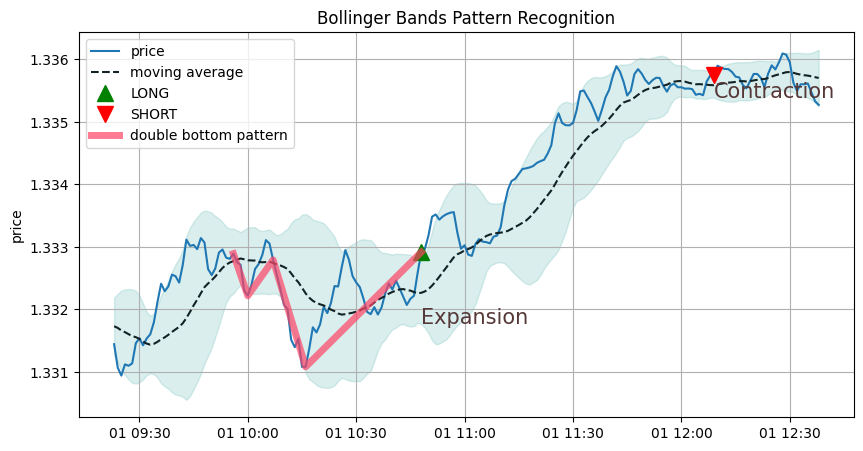

In [11]:
if __name__ == '__main__':
    main()